# Human Mobility Prediction: A Deep Dive with Transformers

Welcome! This notebook is a hands-on guide to our project on predicting human mobility trajectories using a powerful Transformer-based model. We'll explore the dataset, understand how the model works, and run inference to generate predictions.

**Learning Objectives:**
- Understand the human mobility dataset and the prediction challenge.
- Learn the core concepts behind our T5-based trajectory prediction model.
- Run inference with different strategies (greedy, sampling, beam search).
- Visualize and evaluate the generated trajectories.
- Peek inside the model's "brain" with attention visualization.


## 1. Understanding the Dataset

The core of our project is a dataset that tracks the movement of individuals within a city over several days. Each row represents a person's location at a specific time.

**Dataset Columns:**
- `uid`: A unique identifier for each user.
- `d`: The day ID (e.g., day 1, day 2, ...).
- `t`: The time slot of the day, divided into 30-minute intervals (0-47).
- `x`, `y`: The spatial coordinates of the user.

**The Challenge:** The dataset contains future records where the coordinates are marked as `(999, 999)`. Our goal is to predict these missing `x` and `y` coordinates based on the user's historical movement patterns.

Let's load a sample of the data to see what it looks like.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add project root to path to allow importing utility functions
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))


# --- Load Data ---
CITY = 'A'
print("Loading a sample of the data...")
# We use the raw data file for this initial exploration
DATA_PATH = os.path.join('..', 'dataset_parquet', f'city_{CITY}_challengedata_clustered_enriched.parquet')

# Load a subset for quick analysis
df = pd.read_parquet(DATA_PATH)
df = df[df['x'] != 999]
print("Data loaded successfully.")
print(df.head())

# --- Basic Statistics ---
print("\\n--- Basic Statistics (from the sample) ---")
n_users = df['uid'].nunique()
n_days = df['d'].nunique()
min_day, max_day = df['d'].min(), df['d'].max()
min_x, max_x = df['x'].min(), df['x'].max()
min_y, max_y = df['y'].min(), df['y'].max()

print(f"- Number of unique users in sample: {n_users}")
print(f"- Number of days in sample: {n_days} (from day {min_day} to {max_day})")
print(f"- X coordinate range: [{min_x}, {max_x}]")
print(f"- Y coordinate range: [{min_y}, {max_y}]")


Loading a sample of the data...
Data loaded successfully.
   uid  d   t   x    y        loc  cluster  cluster_idx  day_of_week  \
0    1  1  38  96  133  (96, 133)       11           11            0   
1    1  1  39  97  133  (97, 133)       11           11            0   
2    1  3  14  94  146  (94, 146)       11           11            2   
3    1  3  15  82  140  (82, 140)       11           11            2   
4    1  3  23  80  141  (80, 141)       11           11            2   

   time_delta_encoded  
0                   0  
1                   1  
2                   6  
3                   1  
4                   4  
\n--- Basic Statistics (from the sample) ---
- Number of unique users in sample: 150000
- Number of days in sample: 75 (from day 1 to 75)
- X coordinate range: [1, 200]
- Y coordinate range: [1, 200]


### Visualizing Mobility Patterns

A great way to understand the data is to visualize it. Let's look at two things:
1.  **Spatial Heatmap:** Where are the "hotspots" in the city that people visit most frequently?
2.  **Individual Trajectory:** What does the path of a single user look like over time?


\n--- Analyzing Spatial Distribution ---


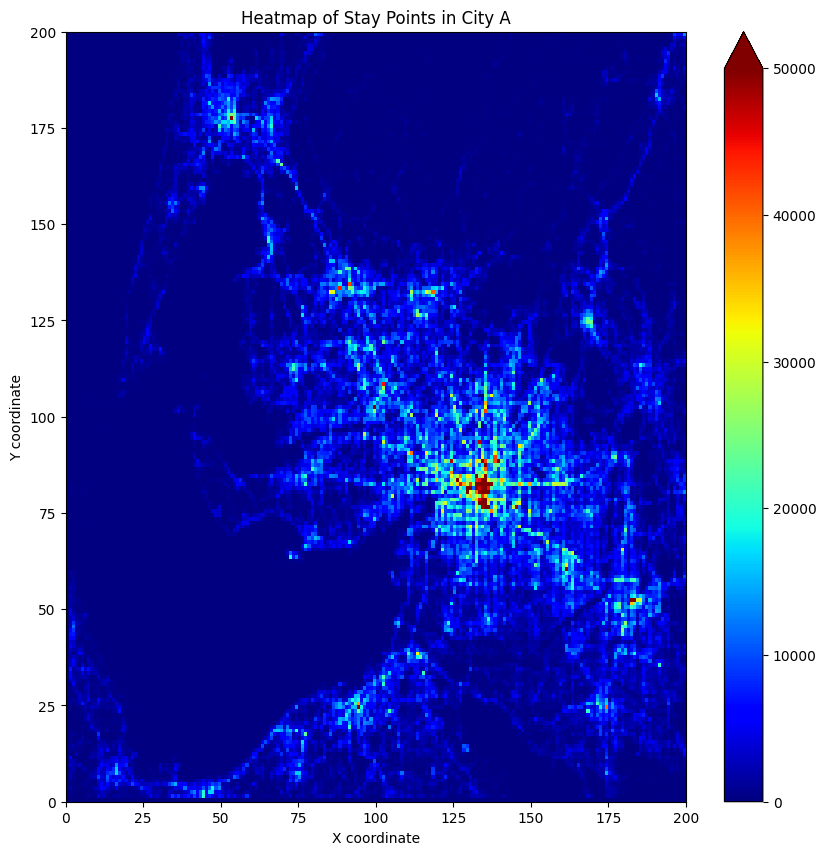

\n--- Visualizing an Individual Trajectory ---


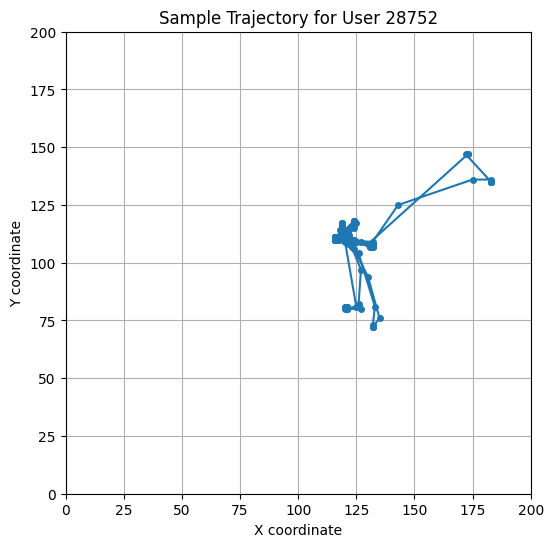

In [2]:
# --- 4. Spatial Distribution of Stay Points ---
print("\\n--- Analyzing Spatial Distribution ---")
# Filter out the unknown points for visualization
known_points = df[df['x'] != 999]

plt.figure(figsize=(10, 10))
plt.hist2d(known_points['x'], known_points['y'], bins=(200, 200), cmap=plt.cm.jet, range=[[0, 200], [0, 200]])
plt.colorbar(extend='max')
plt.clim(0, 50000)
plt.title('Heatmap of Stay Points in City A')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

# --- 5. Visualizing an Individual Trajectory ---
print("\\n--- Visualizing an Individual Trajectory ---")

# Pick a user with a decent number of points from our sample
user_id_to_plot = known_points['uid'].value_counts().index[0]
user_df = known_points[known_points['uid'] == user_id_to_plot].sort_values(by=['d', 't'])

plt.figure(figsize=(6, 6))
plt.plot(user_df['x'], user_df['y'], marker='o', linestyle='-', markersize=4)
plt.title(f'Sample Trajectory for User {user_id_to_plot}')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.grid(True)
plt.show()


## 2. The Transformer-Based Approach

How can we predict a sequence of future locations? This is a **sequence-to-sequence** problem, which Transformer models are exceptionally good at. We use a modified **T5 (Text-to-Text Transfer Transformer)** model for this task.

But wait, T5 is a language model. How does it understand locations?

### Tokenization: Turning Trajectories into a Language

The key is **tokenization**. We convert the continuous stream of trajectory data (`x`, `y`) into a vocabulary of discrete tokens, just like turning a sentence into a sequence of words.

 **Our Model Input Features:**
 - **Coordinate Tokens:** `x_0`, `x_1`, ..., `x_199` and `y_0`, `y_1`, ..., `y_199` (tokenized)
 - **Time Features:** Time of day (0-47) fed directly to embedding layer
 - **Day of Week Features:** Day (0-6) fed directly to embedding layer  
 - **Time Delta Features:** Time difference (0-6) fed directly to embedding layer
 - **Special Tokens:** `[START]`, `[END]`, `[PAD]` (for padding coordinate sequences)

A single point in a trajectory like `(x=45, y=120, t=10, dow=1)` gets converted into a sequence of embeded features: `[x_45, y_120, t_10, dow_1]`.

### Model Input & Output

The model has an **Encoder-Decoder** structure:

1.  **Encoder Input (The Past):** The encoder receives the user's *past trajectory* as a sequence of tokens. This gives the model the historical context of the user's movement patterns.
    -   `Example: [x_45, y_120, t_10, ..., x_46, y_122, t_11, ..., END]`

2.  **Decoder Input (The Future Context):** The decoder receives the *temporal information* for the future time steps we want to predict (e.g., the time of day, day of the week). It uses this, along with the information from the encoder, to make predictions.
    -   `Example: [START, t_13, dow_1, ...]`

3.  **Decoder Target (The Prediction):** The model is trained to predict the *sequence of coordinate tokens* for the future time steps.
    -   `Example: [x_50, y_130, x_52, y_135, ..., END]`


## 3. The Training Process

The model learns to predict trajectories by being trained on a large dataset of historical movements. Here's a simplified overview of the process:

1.  **Time-Based Splitting:** We don't split the data randomly. To simulate a real-world prediction scenario, we use a time-based split:
    -   **Training Data:** User trajectories from days 1-40.
    -   **Validation Data:** Trajectories from days 41-50 (used to tune the model).
    -   **Test Data:** Trajectories from days 51-60 (used for final evaluation).

2.  **Teacher Forcing:** During training, we use a technique called *teacher forcing*. At each step, instead of feeding the model's own (potentially incorrect) previous prediction to predict the next point, we feed it the *correct* previous point from the ground truth. This stabilizes training and helps the model learn the patterns more effectively.

3.  **Loss Function:** The model's performance is measured by a **cross-entropy loss**. This loss calculates how different the model's predicted probability distribution over the vocabulary is from the actual ground truth token. The training process aims to minimize this loss.


## 4. Hands-On Inference: Let's Predict!

Now for the exciting part! We'll load a pre-trained model and use it to generate trajectory predictions for a sample user.

### 4.1. Setup: Imports and Helper Functions

First, we need to import the necessary libraries and define some helper functions for loading the model, calculating metrics, and visualization.


In [3]:
import torch
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary classes from our project
from models.trajectory_tokenizer import TrajectoryTokenizer
from models.trajectory_transformer import TrajectoryT5
from utils.trajectory_dataloader import MixedTrajectoryDataManager

# Helper function to load the model from a checkpoint
def load_model_from_checkpoint(checkpoint_path: str, data_manager: MixedTrajectoryDataManager, device: torch.device) -> TrajectoryT5:
    """Load model from checkpoint."""
    print(f"Loading model from {checkpoint_path}...")
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found at {checkpoint_path}")
        
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    training_args = checkpoint.get('args', {})
    model_name = training_args.get('model_name', 't5-small')
    
    tokenizer = TrajectoryTokenizer()
    cluster_info = data_manager.get_cluster_info()
    num_clusters = cluster_info.get('num_clusters', 100)
    model = TrajectoryT5(tokenizer, model_name=model_name, from_pretrained=False, num_clusters=num_clusters)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"✓ Model loaded successfully (Epoch: {checkpoint.get('epoch', 'Unknown')})")
    return model

# Helper function to calculate metrics
def calculate_simple_metrics(pred_coords, gt_coords):
    """Calculate simple metrics for quick evaluation."""
    if len(pred_coords) == 0 or len(gt_coords) == 0 or len(pred_coords) != len(gt_coords):
        return {'success': False, 'reason': 'Length mismatch or empty'}
    
    distances = [((p[0] - g[0])**2 + (p[1] - g[1])**2)**0.5 for p, g in zip(pred_coords, gt_coords)]
    exact_matches = sum(1 for p, g in zip(pred_coords, gt_coords) if p == g)

    return {
        'avg_distance': np.mean(distances),
        'max_distance': np.max(distances),
        'exact_matches': exact_matches,
        'accuracy': exact_matches / len(pred_coords),
        'success': True,
        'distances': distances
    }

# Helper function to visualize the trajectory
def visualize_sample(past_coords, pred_coords, gt_coords, metrics, uid):
    """Create a simple visualization of the trajectory prediction."""
    plt.figure(figsize=(12, 8))
    
    if past_coords:
        past_x, past_y = zip(*past_coords)
        plt.plot(past_x, past_y, 'b-o', label='Past Trajectory', alpha=0.7, markersize=4)
    
    if pred_coords:
        pred_x, pred_y = zip(*pred_coords)
        plt.plot(pred_x, pred_y, 'r-s', label='Predicted', alpha=1, markersize=5)
    
    if gt_coords:
        gt_x, gt_y = zip(*gt_coords)
        plt.plot(gt_x, gt_y, 'g-^', label='Ground Truth', alpha=0.8, markersize=5)
    
    if past_coords and (pred_coords or gt_coords):
        last_past = past_coords[-1]
        if pred_coords: plt.plot([last_past[0], pred_coords[0][0]], [last_past[1], pred_coords[0][1]], 'r--', alpha=0.5)
        if gt_coords: plt.plot([last_past[0], gt_coords[0][0]], [last_past[1], gt_coords[0][1]], 'g--', alpha=0.5)
            
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f'Trajectory Prediction - UID: {uid}\\n'
              f'Avg Distance: {metrics.get("avg_distance", "N/A"):.2f}, '
              f'Accuracy: {metrics.get("accuracy", 0)*100:.1f}%')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

    # 3d line plot, z is the order of the trajectory, x is longitude, y is latitude
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    past_length = np.arange(len(past_coords))
    future_length = np.arange(past_length.max(), past_length.max()+len(pred_coords))
    ax.plot(gt_x, gt_y, future_length, color="green", label="Ground Truth")
    ax.plot(pred_x, pred_y, future_length, color="red", label="Generated", alpha=0.5)
    #plot past trajectory
    ax.plot(past_x, past_y, past_length, color="blue", label="Past Trajectory", alpha=0.5)
    # add z axis title and rotate 90 degrees
    ax.set_zlabel('Time', rotation=90)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.legend()
    plt.show()


print("Setup complete. Helper functions are defined.")


/Users/mmai/anaconda3/envs/gis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Helper functions are defined.


### 4.2. Run Inference and Tune Parameters

Here is the main code block for inference. You can change the parameters in the **"Student-Tunable Parameters"** section to see how they affect the model's predictions.

**Generation Strategies:**
-   `greedy`: Always picks the most likely next token. Fast and deterministic, but can be repetitive.
-   `sampling`: Samples from the probability distribution of the next token. More creative and diverse.
    -   `top_k`: Considers only the `k` most likely tokens for sampling. A smaller `k` makes it less random.
    -   `temperature`: Controls the "creativity" of the sampling. Higher temperature (>1.0) makes it more random; lower temperature (<1.0) makes it more like greedy search.
-   `beam`: Explores multiple possible prediction paths (beams) simultaneously and chooses the one with the highest overall probability. Often produces better results than greedy but is slower.
    -   `beam_width`: The number of paths to explore.


In [4]:
# Import the load_enriched_data function (adapted from generate_trajectories.py)
import pickle
import json
from scripts.generate_trajectories import load_enriched_data, load_model_from_checkpoint

# --- Configuration (using enriched parquet data like generate_trajectories.py) ---
CHECKPOINT_PATH = os.path.join('..', 'checkpoints', 'trajectory_transformer', f'best_model_{CITY}.pt')
PARQUET_PATH = os.path.join('..', 'dataset_parquet', f'city_{CITY}_challengedata_clustered_enriched.parquet')
TARGET_DAYS = (65, 75)  # Validation period: days 41-50
TARGET_UIDS = (1, 20)   # First 20 users for quick demo
MAX_ENCODER_STEPS = 250

# --- Device Setup ---
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

# Load data using enriched parquet (consistent with generate_trajectories.py)
if os.path.exists(PARQUET_PATH):
    generation_data = load_enriched_data(PARQUET_PATH, TARGET_DAYS, TARGET_UIDS, MAX_ENCODER_STEPS)
else:
    print(f"⚠️ Enriched parquet not found at {PARQUET_PATH}")
    raise FileNotFoundError(f"Please ensure the enriched parquet file exists: {PARQUET_PATH}")

# Load model with cluster support
metadata_file = os.path.join('..', 'datasets', 'processed', f'{CITY}_mixed_trajectory_metadata.pkl')
if os.path.exists(metadata_file):
    with open(metadata_file, 'rb') as f:
        metadata = pickle.load(f)
        num_clusters = metadata.get('cluster_info', {}).get('num_clusters', 100)
        print(f"Loaded metadata with {num_clusters} clusters")
else:
    num_clusters = 100
    print(f"⚠️ Metadata file not found, using default {num_clusters} clusters")



model = load_model_from_checkpoint(CHECKPOINT_PATH, device, num_clusters)


📁 Loading enriched data from ../dataset_parquet/city_A_challengedata_clustered_enriched.parquet
✓ Loaded 87,042,418 trajectory points for 150,000 users
📅 Day range: 1 - 75
🏷️  Clusters: 34 unique clusters
🔍 Filtered to UIDs 1-20: 20 users
🎯 Target period: days 65-75, 2,212 points
📚 Historical data: days < 65, 11,355 points
🔄 Preparing generation data for 20 users...


Processing users: 100%|██████████| 20/20 [00:00<00:00, 76.39it/s]


✅ Successfully prepared data for 20 users
📊 Data statistics:
   Encoder lengths: avg=249.9, min=249, max=250
   Decoder lengths: avg=110.6, min=40, max=283
Loaded metadata with 34 clusters
Loading model from ../checkpoints/trajectory_transformer/best_model_A.pt
Vocabulary size: 404
Special tokens: PAD=0, START=1, END=2
🔧 Creating T5 model from scratch (offline mode)
✓ Created t5-small model from scratch
Model initialized with vocab size: 404
Added temporal embeddings: t(49), dow(8), td(8)
Added cluster embedding: clusters(35)
Padding indices: t=48, dow=7, td=7, cluster=34
✓ Model loaded successfully (Epoch: 24)
✓ Model supports 34 clusters


In [ ]:
# ==================================
# --- Student-Tunable Parameters ---
# ==================================
GENERATION_STRATEGY = 'sampling'  # Options: 'greedy', 'sampling', 'beam'
TOP_K = 10
TEMPERATURE = 0.5
BEAM_WIDTH = 5
idx = 1
# ==================================
# Select sample user data
sample_user_data = generation_data[idx]  # Select the first user in the validation set
print(f"\\n✓ Ready to predict. Sample user: {sample_user_data['uid']}")
print(f"   Past trajectory length: {sample_user_data['encoder_length']}")
print(f"   Future trajectory length: {sample_user_data['decoder_length']}")


uid = sample_user_data['uid']
cluster_idx = sample_user_data['cluster_idx']
past_coords = sample_user_data['past_coords']
past_temporal = sample_user_data['past_temporal']
future_temporal = sample_user_data['future_temporal']
gt_coords = sample_user_data['target_coords']

print(f"--- Preparing for Inference for UID: {uid} ---")
print(f"Strategy: {GENERATION_STRATEGY}")
if GENERATION_STRATEGY == 'sampling':
    print(f"Top-K: {TOP_K}, Temperature: {TEMPERATURE}")
elif GENERATION_STRATEGY == 'beam':
    print(f"Beam Width: {BEAM_WIDTH}")
print(f"Past trajectory length: {len(past_coords)}")
print(f"Future trajectory length to predict: {len(future_temporal)}")

# --- Run Generation (using the same interface as generate_trajectories.py) ---
start_time = time.time()
with torch.inference_mode():
    if GENERATION_STRATEGY == 'sampling':
        predicted_trajectories = model.generate_trajectory_with_sampling(
            batch_past_coords=[past_coords],
            batch_past_temporal=[past_temporal],
            batch_future_temporal=[future_temporal],
            batch_cluster_indices=[cluster_idx],
            device=device,
            top_k=TOP_K,
            temperature=TEMPERATURE,
        )
    elif GENERATION_STRATEGY == 'beam':
        predicted_trajectories = model.generate_trajectory_with_beam_search(
            batch_past_coords=[past_coords],
            batch_past_temporal=[past_temporal],
            batch_future_temporal=[future_temporal],
            batch_cluster_indices=[cluster_idx],
            device=device,
            beam_width=BEAM_WIDTH,
        )
    else: # greedy
        predicted_trajectories = model.generate_trajectory(
            batch_past_coords=[past_coords],
            batch_past_temporal=[past_temporal],
            batch_future_temporal=[future_temporal],
            batch_cluster_indices=[cluster_idx],
            device=device
        )
inference_time = time.time() - start_time
pred_coords = predicted_trajectories[0]
print(f"\\nInference completed in {inference_time:.3f} seconds.")

# --- Evaluate and Visualize ---
metrics = calculate_simple_metrics(pred_coords, gt_coords)
if metrics['success']:
    print(f"Avg distance error: {metrics['avg_distance']:.2f}")
    print(f"Accuracy (exact matches): {metrics['accuracy']*100:.1f}%")
    visualize_sample(past_coords, pred_coords, gt_coords, metrics, uid)
else:
    print(f"Could not generate valid metrics: {metrics.get('reason', 'Unknown error')}")
    print(f"Predicted length: {len(pred_coords)}, Ground Truth length: {len(gt_coords)}")


\n✓ Ready to predict. Sample user: 2
   Past trajectory length: 250
   Future trajectory length: 283
--- Preparing for Inference for UID: 2 ---
Strategy: sampling
Top-K: 10, Temperature: 0.5
Past trajectory length: 250
Future trajectory length to predict: 283


## 5. Diving Deeper: Attention Visualization

What part of the user's *past* is the model paying attention to when it predicts a *future* location? We can inspect the **cross-attention** mechanism to find out.

The heatmap below shows the attention scores between the decoder (predicting the future) and the encoder (processing the past).

-   **Y-axis:** Decoder tokens (future time steps being predicted).
-   **X-axis:** Encoder tokens (the user's recent past trajectory).
-   **Color Intensity:** A brighter color means the model is paying more attention to that specific past token when generating the future token.

This can help us understand if the model is learning meaningful temporal patterns, like focusing on recent locations or locations from the same time of day last week.


🎨 Visualizing attention for UID 2...
   📏 Total tokens - Encoder: 500, Decoder: 187
   🎯 Visualizing subset - Encoder: 10 (last 10), Decoder: 10 (first 10)


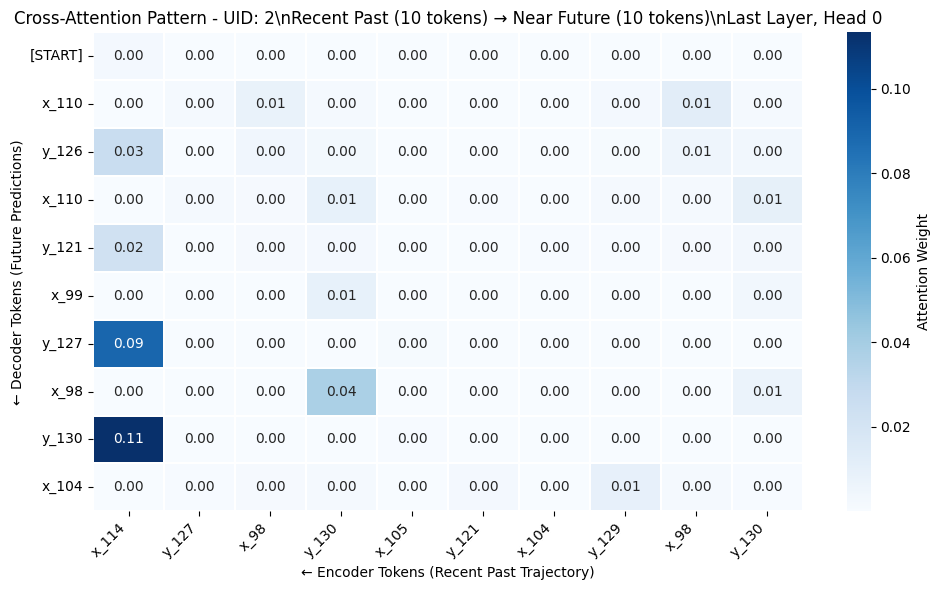

   📊 Attention Statistics:
      Avg attention entropy: 0.894 (Focused)
      🎯 Most attended recent encoder positions:
         1. Pos 490: x_114 (attention: 0.026)
         2. Pos 493: y_130 (attention: 0.007)
         3. Pos 499: y_130 (attention: 0.003)


In [17]:
from scripts.generate_trajectories import visualize_sample_attention

# Run the attention visualization on our sample user data
max_enc_len = 10
max_dec_len = 10
visualize_sample_attention(model, sample_user_data, max_enc_len, max_dec_len, device)


## 6. Conclusion and Next Steps

This notebook provided a comprehensive walkthrough of our human mobility prediction problem. We've covered:
- The structure of the mobility dataset.
- The intuition behind using a Transformer model and tokenization.
- How to run inference with tunable hyperparameters.
- Methods for visualizing and evaluating the predictions.

**Play with the code:**
-   **Experiment:** Try different values for `top_k`, `temperature`, and `beam_width`. How do they change the output? Does one strategy consistently perform better?
-   **Analyze More Samples:** Modify the code to loop through several users from the validation set and compare their results.
-   **Feature Engineering:** Can you think of other features that might help the model? For example, adding information about public holidays or weather.

Thank you for exploring this project!
